In [1]:
import PCE_module as p
import TestFunctions as testf

import numpy as np
import numpy.random as rnd
from scipy.stats import gaussian_kde
from matplotlib import pyplot as plt

%matplotlib inline

# Section 1: Multi-level estimation of first moment of the Ishigami function 

In [2]:
# Both of these functions assume C and C' are 1
def var_ishigami(a, b):
    return b**2*np.pi**8/18 + b*np.pi**4/5 + a**2/8 + 1/2

def var_correction(a, b, a_p, b_p):
    term1 = (3*np.pi**3*(a - a_p)**2 + 4*np.pi**11*(b - b_p)**2/9) / (8*np.pi**3)
    term2 = 16*np.pi**6*(a - a_p)**2 / (64*np.pi**6)
    return term1 - term2

 This code will implement a multilevel Monte Carlo scheme to compute the PCE coefficients and Sobol indices for the Ishigami function defined as:
 
$$  f = \sin(x) + a\sin^2(y) + bz^4\sin(x) $$
$$  f_{low} = \sin(x) + a'\sin^2(y) + b'z^4\sin(x) $$

where $a'$ and $b'$ can be adjusted to approximate $f$ more or less. We will assume for now that $a' = ca, b' = cb$, where $c$ is just some constant shift. We then use the two level control variate setup,

$$  f = f_{low} + (f - f_{low})    ,$$

to efficiently estimate the first moment of $f$. Also not that $x, y, z \sim \mathcal{U}[-\pi, \pi]$.

**Goal #1:** Build a 2 level estimator for $\mathbb{E}[f]$ using $\hat{f}_{low}$ and $\widehat{f - f_{low}}$ where $\hat{f}$ denotes a estimator of the expected value. Thus with a finite number of samples, we want to estimate $\mathbb{E}[f]$ by using the ML estimator to reduce the variance of the estimator $\hat{f}$.

The idea is that for $f$, the variance of the estimator $\hat{f} \approx \mathbb{E}[f]$ is $\mathbb{V}[\hat{f}] = \mathbb{V}[f]/N$ where $N$ is the number of samples used. With this multi-level approach, we should achieve a variance reduction such that $\mathbb{V}[\hat{f}_{low} + \widehat{f - f_{low}}] = \mathbb{V}[f_{low}]/N_0 + \mathbb{V}[f - f_{low}]/N_1$, where we require that $N_0 + N_1 > N$. For the sake of simplcity, we will let $N = \frac{3N_1}{2}$, where the cost of sampling $f_{low}$ and $f - f_{low}$ is not considered. If we wanted, it would be possible to assign computational costs $C_0$ and $C_1$ to computing the ML components, then sample optimal sample allocation results would follow. 

In [3]:
# this block is for testing without need to sample, just analytical values
a = 7.0; b = 0.1; shift = 0.80
N = 10000
N_0 = 7000
N_1 = 10000-N_0
var_flow = var_ishigami(shift*a,shift*b)
var_cor = var_correction(a, b, shift*a, shift*b)
var_ML_estim = var_flow/ N_0 + var_cor/ N_1
print('var f low: ',var_flow)
print('var correction: ', var_cor)
print('variance of ML estimator: ',var_ML_estim)
print('variance of high level estimator:', var_ishigami(a,b)/(N_1*1.5))

var f low:  9.352245373369133
var correction:  0.4558562448015679
variance of ML estimator:  0.0014879871349389702
variance of high level estimator: 0.0030765750979376122


Text(0.5, 0, 'E[f] estimates')

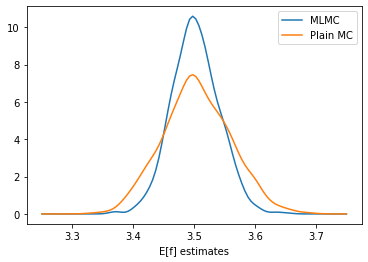

In [8]:
# first we define our variables
shift = 0.80
a = 7.0; b = 0.1; a_prime = 7.0*(shift); b_prime = 0.1*(shift) # so we change it by (shift)
N = 10000 # number of total samples to be allocated 
A = -np.pi; B = np.pi; # these are uniform bounds
# Then we compute realizations of the mean estimator
NN = 1000
mu_full = np.zeros((NN,))
mu_f = np.zeros((NN,))

for i in range(NN):
    samples = np.random.uniform(A, B, (3,N))
    # this is our estimator for E[f] with only high fidelity samples, say 4500 of them
    f_samples_full = testf.Ishigami(samples[:,1:4500], a, b)
    mu_full[i] = np.mean(f_samples_full)
    
    # then we need to split the samples into high and low level
    sample_split = 7000
    flow_samples_split_1 = testf.Ishigami(samples[:,1:sample_split], a_prime, b_prime) # the low level samples
    flow_samples_split_2 = testf.Ishigami(samples[:,sample_split:], a_prime, b_prime) # the low level samples 2
    f_samples_split_2 = testf.Ishigami(samples[:,sample_split:], a, b) # the high level samples 2

    mu_f[i] = np.mean(flow_samples_split_1) + np.mean(f_samples_split_2 - flow_samples_split_2)

# Plot the realizations of the estimated first moment for both schemes  
x_pts = np.linspace(3.25,3.75,100)
plt.plot(x_pts, gaussian_kde(mu_f)(x_pts))
plt.plot(x_pts, gaussian_kde(mu_full)(x_pts))
plt.legend(['MLMC','Plain MC'])
plt.xlabel('E[f] estimates')

In [10]:
# Compare these experimental results with the analytical results above
sample_split = 7000
print('Sampled variance of high level estimator: ',np.var(f_samples_full)/(3000*1.5))
print('Sampled variance of low level f low: ',np.var(flow_samples_split_1))
print('Sampled variance of correction: ',np.var(f_samples_split_2 - flow_samples_split_2))
print('Sampled variance of ML estimator: ',np.var(flow_samples_split_1)/sample_split + np.var(f_samples_split_2 - flow_samples_split_2)/(N-sample_split))

Sampled variance of high level estimator:  0.0030115939397748117
Sampled variance of low level f low:  9.45600128218007
Sampled variance of correction:  0.43861369473654227
Sampled variance of ML estimator:  0.001497061890937905


### Thus using the bi-level estimator, we are able to reduce the variance of the first moment estimator. Next, we seek to do the same for estimating the expectation required to compute PCE coefficients

# Section 2: Multi-level approach to computing PCE coefficients for Ishigami

The goal of this section is to compute a bi-level estimator for the PCE coefficients
$$ \beta_k = \frac{\mathbb{E}[f\Psi_k]}{\mathbb{E}[\Psi_k^2]} \approx  \frac{\widehat{f\Psi_k}}{\mathbb{E}[\Psi_k^2]} \approx \frac{\widehat{f_{low}\Psi_k} + \widehat{(f - f_{low})\Psi_k}}{\mathbb{E}[\Psi_k^2]}$$

We will again assume that $f$ and $f_{low}$ have the same form as in section 1. We then define the costs $C_0$ and $C_1$ for the evaluation cost of $f_{low}$ and the discrepancy $f - f_{low}$. Thus the overall cost that will act as a constraint for the problem is $N_0C_0 + C_1 N_1$, where we simplify the process by assuming that evaluting the orthogonal polynomials does not add any additional cost. In general, if evaluating $f$ corresponds to something like a PDE solve, this is not a bad assumption.

In [11]:
# We start by defining a computational budget, given by N samples
N = 10000 # number of total samples to be allocated 
A = -np.pi; B = np.pi; # these are uniform bounds on the input variables
a = 7.0; b = 0.1; shift = 0.80
# Then we set up the PCE variables and the full set of input samples
multiindices = p.EvalMulti_totdeg(3,3)
P = multiindices.shape[1]
samples_on_ab = rnd.uniform(A, B, (3,N))
samples = p.transf_uniform(samples_on_ab, A, B) 

Now we need to determine $N_0$ and $N_1$, so this requires either an estimate of $\mathbb{V}[f_{low}\Psi_k]$ and $\mathbb{V}[(f - f_{low})\Psi_k]$ or we need to know their analytical values. Because we are trying to estimate $P$ PCE coefficients, this scheme requires variance expressions for $f_{low}\Psi_k$ and $(f - f_{low})\Psi_k$ for $k = 1, \dots, P$. Thus an efficient way to solve this problem might be to use a small, fixed portion of the budget on estimating these variances and then determining samples from there. We will, of course, be able to reuse these samples later, so this should be a low-waste process.

In [12]:
N_test = int(N/10) # let these samples be used to estimate the necessary variances
sampled_polynomials = np.zeros((P, N))
ishigami_evals = np.zeros((N,))
discrepancy_evals = np.zeros((N,))
var_sampled_term1 = np.zeros((P,)) # the jth entry of this vector: estimate of V[f_{low}\Psi_k]
var_sampled_term2 = np.zeros((P,)) # the jth entry of this vector: estimate of V[(f - f_{low})\Psi_k]

# this loop samples the functions and orthogonal polynomials
for i in range(N_test):
    sampled_polynomials[:,i] = p.evaluate_orthogonal_polynomials(multiindices, samples[:,i], 'legendre')
    ishigami_evals[i] = testf.Ishigami(samples_on_ab[:,i], shift*a, shift*b)
    discrepancy_evals[i] = testf.Ishigami(samples_on_ab[:,i], a, b) - testf.Ishigami(samples_on_ab[:,i], a*shift, b*shift)
    
# this loop computes the variance of each term 
for j in range(P):
    var_sampled_term1[j] = np.var(ishigami_evals[:N_test] * sampled_polynomials[j,:N_test])
    var_sampled_term2[j] = np.var(discrepancy_evals[:N_test] * sampled_polynomials[j,:N_test])

In [13]:
%%time
# Here, if we do not specify C_0 and C_1, assuming they are equal, we get the N_0/N_1 ratio:
N_ratio = np.sqrt(var_sampled_term1 / var_sampled_term2) 
N_1 = (N / (N_ratio + 1)).astype(int) #round to nearest int
N_0 = N - N_1

# Here, I do not use all of those sampling values, because we reuse f_low and f for each PCE mode
ishigami_evals[N_test:max(N_0)] = testf.Ishigami(samples_on_ab[:,N_test:max(N_0)], shift*a, shift*b)
discrepancy_evals[N_test:max(N_1)] = testf.Ishigami(samples_on_ab[:,N_test:max(N_1)], a, b) - testf.Ishigami(samples_on_ab[:,N_test:max(N_1)], a*shift, b*shift)
for i in np.arange(N_test,max(N_0)):
    sampled_polynomials[:,i] = p.evaluate_orthogonal_polynomials(multiindices, samples[:,i], 'legendre')


CPU times: user 1.15 s, sys: 8.07 ms, total: 1.16 s
Wall time: 1.7 s


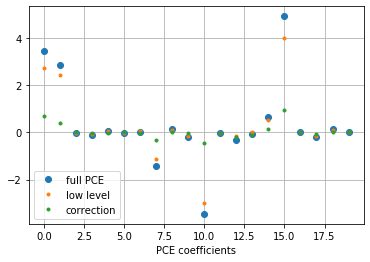

In [14]:
# Now that samples have been allocated and computed, we can estimate PCE coefficients for each mode
polynomial_norms = p.get_polynomial_norms(multiindices, 'legendre')
term1 = np.matmul(sampled_polynomials[:,:max(N_0)], ishigami_evals[:max(N_0)]) / polynomial_norms / max(N_0)
term2 = np.matmul(sampled_polynomials[:,:max(N_1)], discrepancy_evals[:max(N_1)]) / polynomial_norms / max(N_1)
pce_coef = term1 + term2
plt.plot(pce_coef, 'o')
plt.xlabel('PCE coefficients'); plt.grid()
plt.plot(term1, '.')
plt.plot(term2, '.')
plt.legend(('full PCE','low level','correction'))

In [15]:
# These values are computed using a single level PCE with a million samples
pce_true = np.array([ 3.5 ,  2.82,  0.  ,  0.01, -0.01, 0. , -0.02,  -1.33  ,  0.02,
       -0.04, -3.44,  0.01,  0.03, -0.  ,  0.  , 5.27 ,  0.02, -0.03,
       -0.  , -0.06])

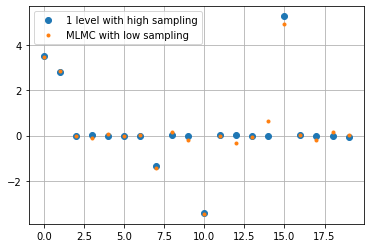

In [16]:
plt.plot(pce_true, 'o')
plt.plot(pce_coef, '.')
plt.grid()
plt.legend(('1 level with high sampling','MLMC with low sampling'))

## We want a group of codes for an MLMC implementation that estimates the kth PCE coefficient:
Inputs: index of coefficient k, total number of samples N, D functions to act as the ML group, total order of PCE expansion, polynomial basis information, some sort of iteration criteria, cost information for each level
Codes:
1. A top level driver that calls to other codes, this also does initialization work
2. Something that estimates the variance iteratively and determines sample allocation
3. Something that evaluates and stores the samples
4. Something that computes the PCE coefficients

In [17]:
# create a class that stores all of the input data for the MLMC PCE task
# the ML class of functions will include the number of levels, the function at each level, the basis, the costs, etc.
class Multi_Level_Model:
    
    def __init__(self, name):
        self.name = name
        self.levels = 0
        self.functions = []
        self.costs = np.array([])
        self.var_analytical = []
    
    def basis(self, basis):
        self.basis = basis
    
    def basis_params(self, basis_params):
        self.basis_params = basis_params
        
    def variables(self, variables):
        self.variables = variables
        
    def add_level(self, level_func, cost, var='n/a'):
        self.levels += 1
        self.functions.append(level_func)
        self.costs = np.append(self.costs, cost)
        self.var_analytical.append(var) # optional: add analytical variance of this level
        
def generate_samples(N, MLM, samples, samples_on_ab):
    '''Given a vector of number of samples to add by level, return input random variables.
    Think of N as a DeltaN_l vector of number of new samples by level'''
    A, B = MLM.basis_params # these can be uniform bounds or normal mu and sigma
    vars = MLM.variables # this needs to be variable, determined by function
    L = MLM.levels
    
    # for initializing the samples
    if not(samples) and not(samples_on_ab):
        samples = [[]]*L; samples_on_ab = [[]]*L
        for i in range(L):
            if MLM.basis == 'legendre':
                samples_on_ab[i] = rnd.uniform(A, B, (vars,N[i]))
                samples[i] = p.transf_uniform(samples_on_ab[i], A, B) 
            elif MLM.basis == 'hermite':
                samples_on_ab[i] = rnd.normal(A, B, (vars,N[i]))
                samples[i] = p.transf_normal(samples_on_ab[i], A, B)
    # for enlarging the samples
    else:
        for i in range(L):
            if MLM.basis == 'legendre':
                newsamples_on_ab = rnd.uniform(A, B, (vars,N[i]))
                newsamples = p.transf_uniform(newsamples_on_ab, A, B) 
                samples_on_ab[i] = np.append(samples_on_ab[i], newsamples_on_ab, axis=1)
                samples[i] = np.append(samples[i], newsamples, axis=1)
            elif MLM.basis == 'hermite':
                newsamples_on_ab = rnd.normal(A, B, (vars,N[i]))
                newsamples = p.transf_normal(newsamples_on_ab, A, B)
                samples_on_ab[i] = np.append(samples_on_ab[i], newsamples_on_ab, axis=1)
                samples[i] = np.append(samples[i], newsamples, axis=1)

    return samples, samples_on_ab

def sample_polynomial(N, MLM, samples, sampled_polynomials, multiindex):
    ''' Takes the newly generated samples and evaluates the orthogonal polynomial.
    Think of N as a DeltaN_l vector of number of new samples by level '''
    if not(sampled_polynomials):
        sampled_polynomials = [[]]*MLM.levels
    else:
        pass
    for i in range(MLM.levels):
        L_update = np.zeros((N[i],))
        start = len(sampled_polynomials[i])
        for j in range(N[i]):
            L_update[j] = p.evaluate_orthogonal_polynomials(multiindex, samples[i][:,start+j], MLM.basis)
        sampled_polynomials[i] = np.append(sampled_polynomials[i], L_update)
    
    return sampled_polynomials

def evaluate_ML_functions(N, MLM, samples_on_ab, function_evals):
    ''' Takes the newly generated samples and evaluates the function at them.
    Think of N as a DeltaN_l vector of number of new samples by level'''
    if not(function_evals):
        function_evals = [[]]*MLM.levels
    else:
        pass
    for i in range(MLM.levels):
        fun_update = np.zeros((N[i],)) 
        start = len(function_evals[i])
        if i == 0:
            fun_update = MLM.functions[i](samples_on_ab[i][:,start:]) # only for first level
        else: 
            fun_update = MLM.functions[i](samples_on_ab[i][:,start:]) - MLM.functions[i-1](samples_on_ab[i][:,start:])
        function_evals[i] = np.append(function_evals[i], fun_update)
    
    return function_evals

def sample_allocation(function_evals, sampled_polynomials, MLM, eps2, N, polynomial_norm):
    '''Evaluates the sample variance with the given function evaluations and returns the optimal 
    sample allocation strategy, given a target variance reduction, subject to total cost. Reference
    for sample allocation: Giles, Michael B. "Multilevel monte carlo methods." Acta Numerica (2015)'''
    var_sampled = np.zeros((MLM.levels,))
    for i in range(MLM.levels):
        # compute sampled variance and store it for each level
        var_sampled[i] = np.var(function_evals[i][:N[i]] * sampled_polynomials[i][:N[i]]) / polynomial_norm
        
    # compute the Lagrange multiplier
    mu = np.sum(np.sqrt( var_sampled * MLM.costs )) / eps2
    N_opt = np.round(mu * np.sqrt(var_sampled / MLM.costs)).astype(int)
    
    return var_sampled, N_opt

In [18]:
# Define a multi-level instance of the Ishigami function, a MLM class
Ishigami = Multi_Level_Model('Ishigami')
Ishigami.basis = 'legendre'
Ishigami.basis_params = np.array([-np.pi, np.pi])
Ishigami.variables = 3
fun1 = lambda x: testf.Ishigami(x, 0.6*7.0, 0.6*0.1)
Ishigami.add_level(fun1, 1.0, testf.var_ishigami(0.6*7.0, 0.6*0.1))
fun2 = lambda x: testf.Ishigami(x, 0.8*7.0, 0.8*0.1)
Ishigami.add_level(fun2, 10.0, testf.var_correction(0.8*7.0, 0.8*0.1, 0.6*7.0, 0.6*0.1))
fun3 = lambda x: testf.Ishigami(x, 7.0, 0.1)
Ishigami.add_level(fun3, 100.0, testf.var_correction(7.0, 0.1, 0.8*7.0, 0.8*0.1))
vars(Ishigami)

{'name': 'Ishigami',
 'levels': 3,
 'functions': [<function __main__.<lambda>(x)>,
  <function __main__.<lambda>(x)>,
  <function __main__.<lambda>(x)>],
 'costs': array([  1.,  10., 100.]),
 'var_analytical': [5.7716152956221425,
  0.45585624480156867,
  0.4558562448015679],
 'basis': 'legendre',
 'basis_params': array([-3.14159265,  3.14159265]),
 'variables': 3}

In [19]:
# This is just a test block of code
samples = []; samples_on_ab = []; SAMP = []; function_evals = []
samples, samples_on_ab = generate_samples([2]*3, Ishigami, samples, samples_on_ab)
print(samples_on_ab)

SAMP = sample_polynomial([2]*3, Ishigami, samples, SAMP, np.array([0,1,0]))
print(SAMP)

function_evals = evaluate_ML_functions([2]*3, Ishigami, samples_on_ab, function_evals)
print(function_evals)

sample_allocation(function_evals, SAMP, Ishigami, .01, [2]*3, 1)

[array([[-1.86895058, -0.51708595],
       [-2.75585977, -2.62806795],
       [-0.7368569 , -2.03779949]]), array([[ 1.84108812, -1.82074372],
       [ 2.82059982, -2.1934153 ],
       [-2.61500668, -0.21750036]]), array([[-1.5908261 , -1.91760472],
       [ 0.02785324, -2.2676416 ],
       [ 2.21872321, -1.91001459]])]
[array([-0.87721741, -0.83654001]), array([ 0.89782481, -0.69818577]), array([ 0.00886596, -0.72181274])]
[array([-0.37825615,  0.00774134]), array([1.04064455, 0.92384315]), array([-0.48348288,  0.57299394])]


(array([0.02860983, 0.62357132, 0.04188322]), array([ 80, 118,  10]))

In [20]:
def estimate_kth_pce_coef(k, eps2, MLM, max_iters):
    '''This code estimates the kth PCE coefficient using a L level MLMC scheme. 
    The essential inputs are the index of the coefficient k, the target accuracy eps2,
    a and multi level function class with the other relevant pieces.'''
    
    vars = MLM.variables # this needs to be variable, determined by function
    L = MLM.levels
    C = MLM.costs
    
    # Initialization: set up the PCE variables and the full set of input samples
    multiindices = p.EvalMulti_totdeg(vars,k) # must be a better way for this
    P = multiindices.shape[1]
    delta_N = [20]*L   # start with 20 pilot samples
    N_opt = [20]*L
    samples = []; samples_on_ab = []
    sampled_polynomials = []
    polynomial_norm = p.get_polynomial_norms(multiindices[:,k], MLM.basis)    
    function_evals = []
    var_sampled = np.zeros((L,))
    iters = 1
    
    # the main iteration that allocates samples and evaluates the MLM
    while max(delta_N) > 0 and iters < max_iters:
        samples, samples_on_ab = generate_samples(delta_N, MLM, samples, samples_on_ab)
        sampled_polynomials = sample_polynomial(delta_N, MLM, samples, sampled_polynomials, multiindices[:,k])
        function_evals = evaluate_ML_functions(delta_N, MLM, samples_on_ab, function_evals)
        N_opt_old = N_opt
        var_sampled, N_opt = sample_allocation(function_evals, sampled_polynomials, MLM, eps2, N_opt_old, polynomial_norm)
        delta_N_raw = [N_opt[i] - N_opt_old[i] for i in range(L)]
        delta_N = np.array([N_opt[i] - N_opt_old[i] for i in range(L)]).clip(min=0)
        print('Iteration: ',iters)
        print('Sampled variance: ', var_sampled)
        print('Sampling by level: ',N_opt)
        print('Change in sample allocation: ', delta_N_raw)
        iters += 1

    # Post-processing: this is where we sample the ML QoI and compute PCE projections
    numerator = 0
    for i in range(MLM.levels):
        numer_update = np.sum(function_evals[i][:N_opt[i]] * sampled_polynomials[i][:N_opt[i]])
        numerator += ((numer_update) / N_opt[i])
    
    beta_k = numerator / polynomial_norm
    # compute the variance of beta_k one final time, with optimal samples
    for i in range(MLM.levels):
        var_sampled[i] = np.var(function_evals[i][:N_opt[i]] * sampled_polynomials[i][:N_opt[i]]) / polynomial_norm
    total_cost = np.sum(C*N_opt) + np.sum(C[1:]*N_opt[1:]); print('total cost: ', total_cost) # this is an option
    
    # Need to fix this section, the optimal sample does not include the basis contribution
    if 'n/a' in MLM.var_analytical:
        print('cannot determine optimal sampling analytically')
    else: 
        optimal_sampling = np.sum(np.sqrt(MLM.var_analytical * C))/eps2 * np.sqrt(MLM.var_analytical / C)
        #print('optimal sampling ratio: ',optimal_sampling)
     
    estim_var = np.sum(var_sampled / N_opt)
    print('estimated variance of beta k', estim_var)
 
    return function_evals, beta_k, sampled_polynomials, N_opt, total_cost

In [21]:
%%time
k = 0 # estimating the 1st PCE coefficient
function_evals, beta_k, sampled_polynomials, N_opt, total_cost = estimate_kth_pce_coef(k,1e-3,Ishigami,25)
print('beta_k: ',beta_k)
#print('N_opt: ',N_opt)

Iteration:  1
Sampled variance:  [4.39600759 0.37965927 0.63568268]
Sampling by level:  [25198  2342   958]
Change in sample allocation:  [25178, 2322, 938]
Iteration:  2
Sampled variance:  [5.72538095 0.44146018 0.45263855]
Sampling by level:  [26851  2358   755]
Change in sample allocation:  [1653, 16, -203]
Iteration:  3
Sampled variance:  [5.76062287 0.44120979 0.4340587 ]
Sampling by level:  [26615  2329   731]
Change in sample allocation:  [-236, -29, -24]
total cost:  219395.0
estimated variance of beta k 0.0010081153688643162
beta_k:  3.437858787911144
CPU times: user 876 ms, sys: 62.8 ms, total: 939 ms
Wall time: 902 ms


# Now for a Single level/Multi level comparison

In [22]:
# Define a single-level instance of the Ishigami function, a MLM class
Ishigami_SF = Multi_Level_Model('Ishigami_SF')
Ishigami_SF.basis = 'legendre'
Ishigami_SF.basis_params = np.array([-np.pi, np.pi])
Ishigami_SF.variables = 3
fun1 = lambda x: testf.Ishigami(x, 7.0, 0.1)
Ishigami_SF.add_level(fun1, 100.0, testf.var_ishigami(7.0, 0.1))
vars(Ishigami_SF)

{'name': 'Ishigami_SF',
 'levels': 1,
 'functions': [<function __main__.<lambda>(x)>],
 'costs': array([100.]),
 'var_analytical': [13.844587940719254],
 'basis': 'legendre',
 'basis_params': array([-3.14159265,  3.14159265]),
 'variables': 3}

In [24]:
%%time
NN = 10 # number of realizations of PCE coef k
PCE_COEF_MF = np.zeros((NN,)); COST_MF = np.zeros((NN,))
PCE_COEF_SF = np.zeros((NN,)); COST_SF = np.zeros((NN,))
k = 0 # estimating the 1st PCE coefficient
for i in range(NN):
    function_evals, beta_k, sampled_polynomials, total_N, total_cost = estimate_kth_pce_coef(k,1e-3,Ishigami_SF, 25)
    PCE_COEF_SF[i] = beta_k; COST_SF[i] = total_cost
    function_evals, beta_k, sampled_polynomials, total_N, total_cost = estimate_kth_pce_coef(k,1e-3,Ishigami, 25)
    PCE_COEF_MF[i] = beta_k; COST_MF[i] = total_cost

Iteration:  1
Sampled variance:  [7.93992445]
Sampling by level:  [7940]
Change in sample allocation:  [7920]
Iteration:  2
Sampled variance:  [14.25513174]
Sampling by level:  [14255]
Change in sample allocation:  [6315]
Iteration:  3
Sampled variance:  [14.25210667]
Sampling by level:  [14252]
Change in sample allocation:  [-3]
total cost:  1425200.0
estimated variance of beta k 0.000999332402035308
Iteration:  1
Sampled variance:  [5.22844744 0.44238515 0.30914886]
Sampling by level:  [22751  2093   553]
Change in sample allocation:  [22731, 2073, 533]
Iteration:  2
Sampled variance:  [5.65653074 0.45617442 0.46960413]
Sampling by level:  [27035  2428   779]
Change in sample allocation:  [4284, 335, 226]
Iteration:  3
Sampled variance:  [5.68155552 0.46348346 0.46459733]
Sampling by level:  [27060  2444   774]
Change in sample allocation:  [25, 16, -5]
Iteration:  4
Sampled variance:  [5.68331093 0.46300072 0.46570349]
Sampling by level:  [27082  2444   775]
Change in sample allocat

Iteration:  2
Sampled variance:  [13.63268609]
Sampling by level:  [13633]
Change in sample allocation:  [1463]
Iteration:  3
Sampled variance:  [13.74207917]
Sampling by level:  [13742]
Change in sample allocation:  [109]
Iteration:  4
Sampled variance:  [13.72273378]
Sampling by level:  [13723]
Change in sample allocation:  [-19]
total cost:  1372300.0
estimated variance of beta k 0.0009996193683781884
Iteration:  1
Sampled variance:  [6.03879184 0.24246435 0.46200513]
Sampling by level:  [26568  1684   735]
Change in sample allocation:  [26548, 1664, 715]
Iteration:  2
Sampled variance:  [5.80992697 0.44874675 0.47583879]
Sampling by level:  [27543  2421   788]
Change in sample allocation:  [975, 737, 53]
Iteration:  3
Sampled variance:  [5.81463389 0.460625   0.47622416]
Sampling by level:  [27630  2459   791]
Change in sample allocation:  [87, 38, 3]
Iteration:  4
Sampled variance:  [5.81227434 0.46119009 0.48064325]
Sampling by level:  [27704  2468   797]
Change in sample allocat

Text(0.5, 1.0, '1st PCE coefficient, 5,000 samples')

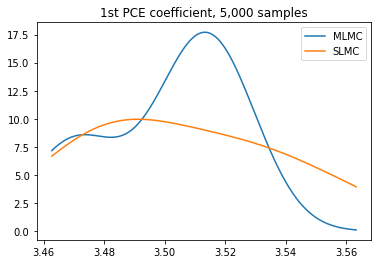

In [25]:
x_pts = np.linspace(min([min(PCE_COEF_MF), min(PCE_COEF_SF)]),max([max(PCE_COEF_MF), max(PCE_COEF_SF)]),1000)
plt.plot(x_pts, gaussian_kde(PCE_COEF_MF)(x_pts))
plt.plot(x_pts, gaussian_kde(PCE_COEF_SF)(x_pts))
plt.legend(['MLMC','SLMC'])
plt.title('1st PCE coefficient, 5,000 samples')
#plt.savefig('PDFs_coef1_SLML', format='pdf')

In [26]:
print('ML mean cost: ',np.mean(COST_MF), '+/-', np.std(COST_MF))
print('SL mean cost: ',np.mean(COST_SF), '+/-', np.std(COST_SF))

ML mean cost:  225420.0 +/- 8512.693345821874
SL mean cost:  1389700.0 +/- 17928.52475804967


In [27]:
%%time
K = np.arange(20) # I want the first K PCE coefficients
N_outer = 10 # the number of realizations of the set of coefs
BETA = np.zeros((K.size,N_outer))
COST = np.zeros((K.size,N_outer))
SAMP = np.zeros((K.size, 3))

for j in range(N_outer):
    for i in range(K.size):
        print('Computing Coefficient ',i)
        f_evals, BETA[i,j], sampled_polynomials, SAMP[i,:], COST[i,j] = estimate_kth_pce_coef(K[i],1e-2,Ishigami, 25)

Computing Coefficient  0
Iteration:  1
Sampled variance:  [3.87893157 0.36829466 0.5679561 ]
Sampling by level:  [2250  219   86]
Change in sample allocation:  [2230, 199, 66]
Iteration:  2
Sampled variance:  [5.73344518 0.39509446 0.43147596]
Sampling by level:  [2622  218   72]
Change in sample allocation:  [372, -1, -14]
Iteration:  3
Sampled variance:  [5.85676044 0.3956442  0.37374422]
Sampling by level:  [2547  209   64]
Change in sample allocation:  [-75, -9, -8]
total cost:  19527.0
estimated variance of beta k 0.01042124880116295
Computing Coefficient  1
Iteration:  1
Sampled variance:  [7.04174448 1.28565277 0.53855959]
Sampling by level:  [3603  487  100]
Change in sample allocation:  [3583, 467, 80]
Iteration:  2
Sampled variance:  [8.06520591 0.88657788 0.79433939]
Sampling by level:  [4183  439  131]
Change in sample allocation:  [580, -48, 31]
Iteration:  3
Sampled variance:  [7.94519897 0.86116773 0.77770974]
Sampling by level:  [4107  428  129]
Change in sample allocat

Iteration:  1
Sampled variance:  [4.35440682 0.80987677 1.91229699]
Sampling by level:  [3915  534  259]
Change in sample allocation:  [3895, 514, 239]
Iteration:  2
Sampled variance:  [9.23722285 0.82168906 0.99754098]
Sampling by level:  [4830  456  159]
Change in sample allocation:  [915, -78, -100]
Iteration:  3
Sampled variance:  [9.17075213 0.76683496 1.04043351]
Sampling by level:  [4845  443  163]
Change in sample allocation:  [15, -13, 4]
Iteration:  4
Sampled variance:  [9.15917809 0.72132047 1.01542537]
Sampling by level:  [4778  424  159]
Change in sample allocation:  [-67, -19, -4]
total cost:  45058.0
estimated variance of beta k 0.010116738688735742
Computing Coefficient  13
Iteration:  1
Sampled variance:  [3.03221032 0.17434337 0.58087003]
Sampling by level:  [1860  141   81]
Change in sample allocation:  [1840, 121, 61]
Iteration:  2
Sampled variance:  [4.92140325 0.34283873 0.59102119]
Sampling by level:  [2608  218   90]
Change in sample allocation:  [748, 77, 9]
It

Iteration:  2
Sampled variance:  [8.09067202 0.85494709 0.95599514]
Sampling by level:  [4422  455  152]
Change in sample allocation:  [729, 219, 72]
Iteration:  3
Sampled variance:  [7.97224628 0.81132669 0.81101898]
Sampling by level:  [4144  418  132]
Change in sample allocation:  [-278, -37, -20]
total cost:  38904.0
estimated variance of beta k 0.010185345252555662
Computing Coefficient  5
Iteration:  1
Sampled variance:  [5.79724394 0.50378562 1.1703128 ]
Sampling by level:  [3725  347  167]
Change in sample allocation:  [3705, 327, 147]
Iteration:  2
Sampled variance:  [8.13955472 0.8862052  0.98097966]
Sampling by level:  [4489  468  156]
Change in sample allocation:  [764, 121, -11]
Iteration:  3
Sampled variance:  [7.99066797 0.87600178 0.9918449 ]
Sampling by level:  [4451  466  157]
Change in sample allocation:  [-38, -2, 1]
Iteration:  4
Sampled variance:  [7.9757947  0.87623897 0.99007995]
Sampling by level:  [4444  466  157]
Change in sample allocation:  [-7, 0, 0]
total

Iteration:  2
Sampled variance:  [13.37984779  1.08441017  1.33690219]
Sampling by level:  [6772  610  214]
Change in sample allocation:  [-7603, 14, -155]
Iteration:  3
Sampled variance:  [13.5261682   1.08742032  1.32118837]
Sampling by level:  [6793  609  212]
Change in sample allocation:  [21, -1, -2]
Iteration:  4
Sampled variance:  [13.5232449   1.08906659  1.33059019]
Sampling by level:  [6808  611  214]
Change in sample allocation:  [15, 2, 2]
Iteration:  5
Sampled variance:  [13.51644939  1.08734334  1.32118837]
Sampling by level:  [6790  609  212]
Change in sample allocation:  [-18, -2, -2]
total cost:  61370.0
estimated variance of beta k 0.010054130243283627
Computing Coefficient  16
Iteration:  1
Sampled variance:  [10.15643218  1.14121427  0.9110761 ]
Sampling by level:  [5134  544  154]
Change in sample allocation:  [5114, 524, 134]
Iteration:  2
Sampled variance:  [10.16833111  1.04742543  0.87662721]
Sampling by level:  [5034  511  148]
Change in sample allocation:  [-

Iteration:  2
Sampled variance:  [15.08661618  1.2853084   1.15668277]
Sampling by level:  [7079  653  196]
Change in sample allocation:  [2403, -360, -45]
Iteration:  3
Sampled variance:  [14.88338106  1.25234481  1.15869648]
Sampling by level:  [7006  643  195]
Change in sample allocation:  [-73, -10, -1]
total cost:  58866.0
estimated variance of beta k 0.010057349011241962
Computing Coefficient  10
Iteration:  1
Sampled variance:  [7.79044188 1.37868144 0.28939532]
Sampling by level:  [3317  441   64]
Change in sample allocation:  [3297, 421, 44]
Iteration:  2
Sampled variance:  [9.23742644 0.85934084 0.7994284 ]
Sampling by level:  [4532  437  133]
Change in sample allocation:  [1215, -4, 69]
Iteration:  3
Sampled variance:  [9.16160397 0.85580017 0.91851099]
Sampling by level:  [4702  454  149]
Change in sample allocation:  [170, 17, 16]
Iteration:  4
Sampled variance:  [9.2227694  0.86241075 0.83445678]
Sampling by level:  [4588  444  138]
Change in sample allocation:  [-114, -1

Iteration:  2
Sampled variance:  [8.784415   0.84139209 0.91545576]
Sampling by level:  [4574  448  148]
Change in sample allocation:  [-961, 5, -20]
Iteration:  3
Sampled variance:  [8.800508   0.83587744 0.93790435]
Sampling by level:  [4611  449  151]
Change in sample allocation:  [37, 1, 3]
Iteration:  4
Sampled variance:  [8.78355103 0.8343606  0.93468063]
Sampling by level:  [4600  448  150]
Change in sample allocation:  [-11, -1, -1]
total cost:  43560.0
estimated variance of beta k 0.010047380986859155
Computing Coefficient  3
Iteration:  1
Sampled variance:  [14.85905767  2.02544454  1.38070122]
Sampling by level:  [7750  905  236]
Change in sample allocation:  [7730, 885, 216]
Iteration:  2
Sampled variance:  [14.30449881  1.25197372  1.19042702]
Sampling by level:  [6895  645  199]
Change in sample allocation:  [-855, -260, -37]
total cost:  59595.0
estimated variance of beta k 0.009923821045056729
Computing Coefficient  4
Iteration:  1
Sampled variance:  [6.88705864 0.58787

Iteration:  2
Sampled variance:  [11.05474719  1.09056146  0.53057516]
Sampling by level:  [4625  459  101]
Change in sample allocation:  [-1926, 76, 11]
Iteration:  3
Sampled variance:  [11.01753062  1.02019405  0.54319822]
Sampling by level:  [4608  443  102]
Change in sample allocation:  [-17, -16, 1]
Iteration:  4
Sampled variance:  [10.99039767  1.0088405   0.54212061]
Sampling by level:  [4593  440  102]
Change in sample allocation:  [-15, -3, 0]
total cost:  33793.0
estimated variance of beta k 0.010022914076206896
Computing Coefficient  15
Iteration:  1
Sampled variance:  [22.15777953  1.08416218  1.22540662]
Sampling by level:  [8976  628  211]
Change in sample allocation:  [8956, 608, 191]
Iteration:  2
Sampled variance:  [12.9778276   1.29731456  0.93788806]
Sampling by level:  [6084  608  164]
Change in sample allocation:  [-2892, -20, -47]
total cost:  51044.0
estimated variance of beta k 0.010283949878494743
Computing Coefficient  16
Iteration:  1
Sampled variance:  [21.6

Iteration:  3
Sampled variance:  [8.24727902 0.79338282 0.97636267]
Sampling by level:  [4471  439  154]
Change in sample allocation:  [113, 11, 9]
Iteration:  4
Sampled variance:  [8.16054356 0.7870236  0.96670172]
Sampling by level:  [4426  435  152]
Change in sample allocation:  [-45, -4, -2]
total cost:  43526.0
estimated variance of beta k 0.010089760093192401
Computing Coefficient  6
Iteration:  1
Sampled variance:  [10.88582734  1.28374011  1.2693024 ]
Sampling by level:  [5988  650  204]
Change in sample allocation:  [5968, 630, 184]
Iteration:  2
Sampled variance:  [12.88874221  1.07843346  1.11406204]
Sampling by level:  [6257  572  184]
Change in sample allocation:  [269, -78, -20]
Iteration:  3
Sampled variance:  [12.92131735  1.03094454  1.09322152]
Sampling by level:  [6205  554  180]
Change in sample allocation:  [-52, -18, -4]
total cost:  53285.0
estimated variance of beta k 0.00998520550238283
Computing Coefficient  7
Iteration:  1
Sampled variance:  [5.42998219 0.410

Iteration:  2
Sampled variance:  [9.59834264 0.6221064  0.85055916]
Sampling by level:  [4590  370  137]
Change in sample allocation:  [-4949, -194, -60]
total cost:  39390.0
estimated variance of beta k 0.00922924366221744
Computing Coefficient  18
Iteration:  1
Sampled variance:  [34.31732283  1.91156406  0.80108719]
Sampling by level:  [11236   839   172]
Change in sample allocation:  [11216, 819, 152]
Iteration:  2
Sampled variance:  [13.3729717   1.19726123  1.14443879]
Sampling by level:  [6515  616  191]
Change in sample allocation:  [-4721, -223, 19]
Iteration:  3
Sampled variance:  [14.02452106  1.17150889  1.30357489]
Sampling by level:  [6960  636  212]
Change in sample allocation:  [445, 20, 21]
Iteration:  4
Sampled variance:  [14.03961027  1.1522103   1.23045646]
Sampling by level:  [6832  619  202]
Change in sample allocation:  [-128, -17, -10]
total cost:  59612.0
estimated variance of beta k 0.010253370548647226
Computing Coefficient  19
Iteration:  1
Sampled variance:

Iteration:  2
Sampled variance:  [9.39791647 0.97309949 0.79147487]
Sampling by level:  [4623  470  134]
Change in sample allocation:  [603, 73, 13]
Iteration:  3
Sampled variance:  [9.38327138 1.05017789 0.74767835]
Sampling by level:  [4580  484  129]
Change in sample allocation:  [-43, 14, -5]
Iteration:  4
Sampled variance:  [9.4007549  1.04625853 0.76679027]
Sampling by level:  [4617  487  132]
Change in sample allocation:  [37, 3, 3]
Iteration:  5
Sampled variance:  [9.38870724 1.04203253 0.75412952]
Sampling by level:  [4589  483  130]
Change in sample allocation:  [-28, -4, -2]
total cost:  40249.0
estimated variance of beta k 0.010069400351803731
Computing Coefficient  11
Iteration:  1
Sampled variance:  [10.5767192   0.30265996  0.42552255]
Sampling by level:  [3745  200   75]
Change in sample allocation:  [3725, 180, 55]
Iteration:  2
Sampled variance:  [6.67472381 0.67711279 0.4598275 ]
Sampling by level:  [3092  311   81]
Change in sample allocation:  [-653, 111, 6]
Iterat

Iteration:  2
Sampled variance:  [8.2275248  0.83105746 0.6751428 ]
Sampling by level:  [4006  403  115]
Change in sample allocation:  [507, 37, 27]
Iteration:  3
Sampled variance:  [8.14899257 0.8844587  0.77399705]
Sampling by level:  [4175  435  129]
Change in sample allocation:  [169, 32, 14]
Iteration:  4
Sampled variance:  [8.15127072 0.86165144 0.85035326]
Sampling by level:  [4286  441  138]
Change in sample allocation:  [111, 6, 9]
Iteration:  5
Sampled variance:  [8.12860852 0.85436813 0.81072753]
Sampling by level:  [4213  432  133]
Change in sample allocation:  [-73, -9, -5]
total cost:  39453.0
estimated variance of beta k 0.010145055796661978
Computing Coefficient  2
Iteration:  1
Sampled variance:  [9.18252634 0.61462691 0.82803157]
Sampling by level:  [4427  362  133]
Change in sample allocation:  [4407, 342, 113]
Iteration:  2
Sampled variance:  [8.62383273 0.79133167 0.83668363]
Sampling by level:  [4375  419  136]
Change in sample allocation:  [-52, 57, 3]
Iteration:

Iteration:  2
Sampled variance:  [11.65469626  1.23913191  0.98268324]
Sampling by level:  [5751  593  167]
Change in sample allocation:  [1499, -123, -46]
Iteration:  3
Sampled variance:  [11.32505534  1.26834534  1.01942617]
Sampling by level:  [5729  606  172]
Change in sample allocation:  [-22, 13, 5]
Iteration:  4
Sampled variance:  [11.33136614  1.2473507   1.01193451]
Sampling by level:  [5708  599  171]
Change in sample allocation:  [-21, -7, -1]
total cost:  51888.0
estimated variance of beta k 0.010038089685221295
Computing Coefficient  15
Iteration:  1
Sampled variance:  [8.18734907 1.51381887 0.78284493]
Sampling by level:  [4464  607  138]
Change in sample allocation:  [4444, 587, 118]
Iteration:  2
Sampled variance:  [13.32528797  1.51200703  0.77407472]
Sampling by level:  [5964  635  144]
Change in sample allocation:  [1500, 28, 6]
Iteration:  3
Sampled variance:  [13.87501367  1.5288885   0.76509578]
Sampling by level:  [6102  641  143]
Change in sample allocation:  [1

Iteration:  2
Sampled variance:  [13.57177559  0.93962847  1.17972534]
Sampling by level:  [6488  540  191]
Change in sample allocation:  [562, -37, 7]
Iteration:  3
Sampled variance:  [13.4847697   0.95338385  1.14733853]
Sampling by level:  [6416  539  187]
Change in sample allocation:  [-72, -1, -4]
total cost:  54596.0
estimated variance of beta k 0.010112204216771337
Computing Coefficient  9
Iteration:  1
Sampled variance:  [22.8417103   1.05668501  1.18774566]
Sampling by level:  [9046  615  206]
Change in sample allocation:  [9026, 595, 186]
Iteration:  2
Sampled variance:  [15.62307297  1.45671558  1.18186667]
Sampling by level:  [7368  711  203]
Change in sample allocation:  [-1678, 96, -3]
Iteration:  3
Sampled variance:  [15.85022692  1.38058001  1.18924647]
Sampling by level:  [7406  691  203]
Change in sample allocation:  [38, -20, 0]
Iteration:  4
Sampled variance:  [15.8895914   1.37441509  1.18924647]
Sampling by level:  [7414  690  203]
Change in sample allocation:  [8

Iteration:  2
Sampled variance:  [8.16296262 0.83136897 0.70508948]
Sampling by level:  [4039  408  119]
Change in sample allocation:  [660, 22, -5]
Iteration:  3
Sampled variance:  [8.22500383 0.86978224 0.69225257]
Sampling by level:  [4054  417  118]
Change in sample allocation:  [15, 9, -1]
Iteration:  4
Sampled variance:  [8.22771324 0.85665157 0.69569068]
Sampling by level:  [4055  414  118]
Change in sample allocation:  [1, -3, 0]
Iteration:  5
Sampled variance:  [8.2258108  0.86179362 0.69569068]
Sampling by level:  [4057  415  118]
Change in sample allocation:  [2, 1, 0]
Iteration:  6
Sampled variance:  [8.22211952 0.86053079 0.69569068]
Sampling by level:  [4055  415  118]
Change in sample allocation:  [-2, 0, 0]
total cost:  35955.0
estimated variance of beta k 0.009997811901083262
Computing Coefficient  2
Iteration:  1
Sampled variance:  [7.78374975 0.78691588 0.82747869]
Sampling by level:  [4099  412  134]
Change in sample allocation:  [4079, 392, 114]
Iteration:  2
Sampl

Iteration:  2
Sampled variance:  [9.98566208 1.03415089 0.96577404]
Sampling by level:  [5120  521  159]
Change in sample allocation:  [825, 124, 11]
Iteration:  3
Sampled variance:  [9.89341426 1.08769627 0.94094922]
Sampling by level:  [5078  532  157]
Change in sample allocation:  [-42, 11, -2]
Iteration:  4
Sampled variance:  [9.85638424 1.07172011 0.95260661]
Sampling by level:  [5078  529  158]
Change in sample allocation:  [0, -3, 1]
Iteration:  5
Sampled variance:  [9.85638424 1.07415435 0.94681586]
Sampling by level:  [5069  529  157]
Change in sample allocation:  [-9, 0, -1]
total cost:  47049.0
estimated variance of beta k 0.010045814271918498
Computing Coefficient  13
Iteration:  1
Sampled variance:  [2.54647622 0.10239762 1.34991564]
Sampling by level:  [2270  144  165]
Change in sample allocation:  [2250, 124, 145]
Iteration:  2
Sampled variance:  [4.53306687 0.2947168  0.56647651]
Sampling by level:  [2421  195   86]
Change in sample allocation:  [151, 51, -79]
Iteration

Iteration:  2
Sampled variance:  [12.9466556   1.07668524  1.08838935]
Sampling by level:  [6229  568  181]
Change in sample allocation:  [1296, -249, 36]
Iteration:  3
Sampled variance:  [13.11559788  1.14007655  1.21239499]
Sampling by level:  [6522  608  198]
Change in sample allocation:  [293, 40, 17]
Iteration:  4
Sampled variance:  [13.05116309  1.10683406  1.15667393]
Sampling by level:  [6392  589  190]
Change in sample allocation:  [-130, -19, -8]
total cost:  56172.0
estimated variance of beta k 0.010267637524471969
Computing Coefficient  7
Iteration:  1
Sampled variance:  [6.56799446 0.3244372  0.25650475]
Sampling by level:  [2416  170   48]
Change in sample allocation:  [2396, 150, 28]
Iteration:  2
Sampled variance:  [5.17996115 0.38802958 0.2993479 ]
Sampling by level:  [2212  191   53]
Change in sample allocation:  [-204, 21, 5]
Iteration:  3
Sampled variance:  [5.23701996 0.47310615 0.29190533]
Sampling by level:  [2258  215   53]
Change in sample allocation:  [46, 24,

Iteration:  2
Sampled variance:  [10.02841835  0.70849334  0.883538  ]
Sampling by level:  [4822  405  143]
Change in sample allocation:  [-807, -233, 40]
Iteration:  3
Sampled variance:  [9.93417272 0.84107228 0.74018221]
Sampling by level:  [4619  425  126]
Change in sample allocation:  [-203, 20, -17]
Iteration:  4
Sampled variance:  [9.83749742 0.82702774 0.82305593]
Sampling by level:  [4731  434  137]
Change in sample allocation:  [112, 9, 11]
Iteration:  5
Sampled variance:  [9.94598354 0.81624452 0.77166541]
Sampling by level:  [4666  423  130]
Change in sample allocation:  [-65, -11, -7]
total cost:  39126.0
estimated variance of beta k 0.010267925908258625
Computing Coefficient  18
Iteration:  1
Sampled variance:  [4.99613746 0.40493924 1.72241615]
Sampling by level:  [3883  350  228]
Change in sample allocation:  [3863, 330, 208]
Iteration:  2
Sampled variance:  [15.04460104  0.89639274  1.30408164]
Sampling by level:  [7095  548  209]
Change in sample allocation:  [3212, 19

<ErrorbarContainer object of 3 artists>

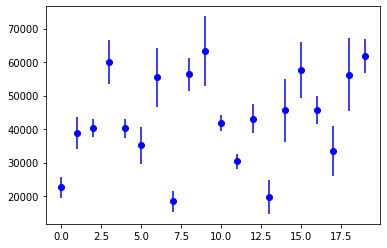

In [28]:
#plt.plot(np.std(COST, 1), 'o')
plt.errorbar(np.arange(BETA.shape[0]), np.mean(COST, 1), np.std(COST, 1), fmt='bo')

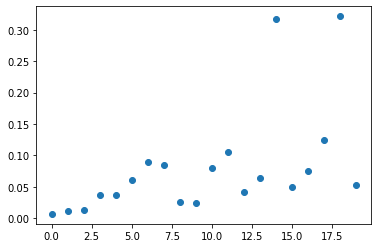

In [29]:
plt.plot(np.var(BETA, 1) , 'o')

Text(0.5, 1.0, 'total cost of estimating each PCE coefficient')

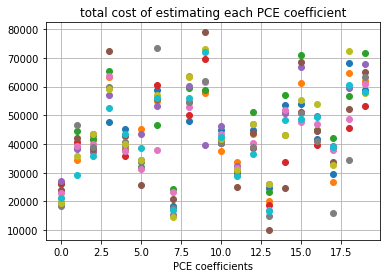

In [30]:
plt.plot(COST, 'o')
plt.xlabel('PCE coefficients')
plt.grid()
plt.title('total cost of estimating each PCE coefficient')
#plt.savefig('pcecoefs_ctot', format='pdf')